In [ ]:
import gurobipy as gp
import os
import shutil


class MILPFindReboundPath:
    """
    MILPFindReboundPath
    使用MILP寻找Rebound友好的截断差分路线
    """

    def __init__(self, ciphername, rounds, begin_round, end_round) -> None:
        self.__model = gp.Model()
        self.__model.setParam(gp.GRB.Param.OutputFlag, False)

        self.__ciphername = ciphername
        self.__rounds = rounds

        self.__num_blocks = 12
        self.__block_size = 16
        # self.__state_size = 16
        self.__state_size = self.__num_blocks * self.__block_size ##192

        self.__key_size = 16 * 12
        self.__state_vars = []
        self.__auxi_vars = []
        self.__aes_type = 128 * 12 #########注意这里改乘12放宽了约束

        self.__InboundCeil = 16 * 12 * 5
        self.__DisCeil = 8 * 16 * 12 * 6
        self.__LastCeil = 16 * 6 #####################不用乘8
        self.__ColiCeil = 8 * 16 * 12 * 4

        self.__inbound_begin_round = begin_round
        self.__inbound_end_round = end_round
        # block activation matrix: 默认全部激活（rounds x num_blocks）
        # 可以通过 set_block_activation 方法设置为只部分块激活
        self.__block_active = [[True for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]

        self.__milp_lpfile_folder = ""
        self.__milp_lpfile_name = ""

        # === 初始化 fixed_mask ===
        # self.__fixed_mask = {}
        # r = 0
        # print(self.__fixed_mask)

        # 整块置 0
        # for b in [0, 1, 2, 3, 6, 7]:
        # for b in [3, 6, 7]:
        #     for i in range(self.__block_size):
        #         self.__fixed_mask[(r, b, i)] = 0

        # 剩余块：index=0 -> 1，其余 -> 0
        # for b in range(self.__num_blocks):
        #     if b not in [0, 1, 2, 3, 6, 7]:
        #         for i in range(self.__block_size):
        #             if i == 0:
        #                 self.__fixed_mask[(r, b, i)] = 1
        #             else:
        #                 self.__fixed_mask[(r, b, i)] = 0


    def generate_variables(self) -> None:
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        num_blocks = self.__num_blocks
        block_size = self.__block_size
        num_cols = 4

        # 清理旧变量（防止重复调用时追加）
        self.__state_vars = []
        self.__auxi_vars = []

        # for r in range(rounds+1): ###########让多循环一轮
        #     round_vars = []
        #     for b in range(num_blocks):
        #         block_vars = []
        #         for i in range(block_size):
        #             block_vars.append(model.addVar(vtype=gp.GRB.BINARY, name=f"x_{r}_{b}_{i}"))
        #         round_vars.append(block_vars)
        #     self.__state_vars.append(round_vars)

        fixed_mask = [[[-1 for _ in range(block_size)] for _ in range(num_blocks)] for _ in range(rounds+1)]
        # for b in range(1):
        #     for i in range(4):
        #         fixed_mask[0][b][i] = 1


        for r in range(rounds):
            round_vars = []
            for b in range(num_blocks):
                block_vars = []
                for i in range(block_size):
                    # if (r, b, i) in fixed_mask:
                    #     # 固定常量：直接用一个“虚拟变量”代替
                    #     const_val = fixed_mask[(r, b, i)]
                    #     print(const_val)
                    #     v = model.addVar(vtype=gp.GRB.BINARY, name=f"x_{r}_{b}_{i}")
                    #     model.addConstr(v == const_val)
                    # else:
                    v = model.addVar(vtype=gp.GRB.BINARY, name=f"x_{r}_{b}_{i}")
                    block_vars.append(v)
                    # if fixed_mask is not None:
                    if fixed_mask[r][b][i] == 0:
                        model.addConstr(v == 0, name=f"fix0_{r}_{b}_{i}_0")
                    elif fixed_mask[r][b][i] == 1:
                        model.addConstr(v == 1, name=f"fix1_{r}_{b}_{i}_1")

                round_vars.append(block_vars)
            self.__state_vars.append(round_vars)

        for r in range(rounds - 1): #######辅助变量也多循环一轮
            round_auxi = []
            for b in range(num_blocks):
                block_auxi = []
                for c in range(num_cols):
                    block_auxi.append(model.addVar(vtype=gp.GRB.BINARY, name=f"d_{r}_{b}_{c}"))
                round_auxi.append(block_auxi)
            self.__auxi_vars.append(round_auxi)

        model.update()
        print(self.__state_vars)

    def mds_cocnstraints(self, var_in, var_out, auxi_var) -> None:
        model = self.__model
        model.addConstr(sum(var_in) + sum(var_out) - 5 * auxi_var >= 0)
        model.addConstr(sum(var_in) - auxi_var >= 0)
        model.addConstr(sum(var_out) - auxi_var >= 0)
        for i in range(4):
            model.addConstr(auxi_var - var_in[i] >= 0)
            model.addConstr(auxi_var - var_out[i] >= 0)
        model.update()

    def aes_round(self, index_in:int, index_out: int, r: int) -> None:
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        state_vars = self.__state_vars
        block_in = self.__state_vars[r][index_in]
        block_out = self.__state_vars[r + 1][index_out]
        auxi_block = self.__auxi_vars[r][index_out]

        index = [[0, 5, 10, 15], [4, 9, 14, 3], [8, 13, 2, 7], [12, 1, 6, 11]]
        # for r in range(rounds - 1):
        for i in range(4):
            var_in = []
            var_out = []
            for j in range(4):
                var_in.append(block_in[index[i][j]])
            for j in range(4):
                var_out.append(block_out[4 * i + j])
            self.mds_cocnstraints(var_in, var_out, self.__auxi_vars[r][index_out][i])

        # for i in range(4):
        #     var_in = []
        #     var_out = []
        #     for j in range(4):
        #         var_in.append(block_in[4*i + j])
        #     for j in range(4):
        #         var_out.append(block_out[4*i + j])
        #     self.mds_cocnstraints(var_in, var_out, self.__auxi_vars[r][index_out][i])


    def aes_temp(self, block_in, block_out, index_out, r) -> None:
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        state_vars = self.__state_vars

        index = [[0, 5, 10, 15], [4, 9, 14, 3], [8, 13, 2, 7], [12, 1, 6, 11]]
        # for r in range(rounds - 1):
        for i in range(4):
            var_in = []
            var_out = []
            for j in range(4):
                var_in.append(block_in[index[i][j]])
            for j in range(4):
                var_out.append(block_out[4 * i + j])
            self.mds_cocnstraints(var_in, var_out, self.__auxi_vars[r][index_out][i])

        # for i in range(4):
        #     var_in = []
        #     var_out = []
        #     for j in range(4):
        #         var_in.append(block_in[4*i + j])
        #     for j in range(4):
        #         var_out.append(block_out[4*i + j])
        #     self.mds_cocnstraints(var_in, var_out, self.__auxi_vars[r][index_out][i])


    def xor_block_constraints(self, r, index_in1, index_in2, index_out) -> None:
        """
        为两个块的 XOR 构建 MILP 约束
        block_in1, block_in2, block_out: 列表 长度为16 每个元素是Gurobi二进制变量
        """
        # model = self.__model
        # for i in range(16):
        #     x = block_in1[i]
        #     y = block_in2[i]
        #     z = block_out[i]

        #     # XOR 活跃性约束
        #     model.addConstr(z >= x)
        #     model.addConstr(z >= y)
        #     model.addConstr(z <= x + y) ###############一般似乎也不考虑1+1=0的情况，默认1+1是1
        
        # model.update()
        model = self.__model
        state_vars = self.__state_vars


        block_in1 = state_vars[r][index_in1]
        block_in2 = state_vars[r][index_in2]
        block_out = state_vars[r + 1][index_out]

        for i in range(16):
            x = block_in1[i]
            y = block_in2[i]
            z = block_out[i]

            # XOR 活跃性约束想 
            model.addConstr(z >= x)
            model.addConstr(z >= y)
            model.addConstr(z <= x + y)  # 默认1+1=1
            ##########################################这里异或的逻辑是1+1一定出1，可以把这部分建模一下
        model.update()

    def xor_block_constraints_tmp(self, r, block_in1, block_in2, block_out) -> None:
        """
        为两个块的 XOR 构建 MILP 约束
        block_in1, block_in2, block_out: 列表 长度为16 每个元素是Gurobi二进制变量
        """
        model = self.__model
        for i in range(16):
            x = block_in1[i]
            y = block_in2[i]
            z = block_out[i]

            # XOR 活跃性约束
            model.addConstr(z >= x)
            model.addConstr(z >= y)
            model.addConstr(z <= x + y) ###############一般似乎也不考虑1+1=0的情况，默认1+1是1
        
        model.update()

    def aes_then_xor(self, index_in: int, index_in2: int, index_out: int, r: int) -> None:
        """
        block_in  : 先过 AES 的块
        block_in2 : 与 AES 输出 XOR 的块
        block_out : 输出块
        r         : 当前轮号
        """
        # 1. AES 输出到临时块
        # block_tmp = [self.__model.addVar(vtype=gp.GRB.BINARY, name=f"tmp_r{r}_{i}") for i in range(16)]
        # self.aes_round(block_in, block_tmp, r)  # AES约束

        # # 2. XOR 临时块与 block_in2，得到最终输出
        # self.xor_block_constraints(block_tmp, block_in2, block_out)
        # 1. AES 输出到临时块
        model = self.__model
        rounds = self.__rounds
        state_size = self.__state_size
        state_vars = self.__state_vars

        # block_tmp = [self.__model.addVar(vtype=gp.GRB.BINARY, name=f"tmp_r{r}_{i}") for i in range(16)]
        block_tmp = self._fix_tmp_naming_and_create_tmp(r, index_out)

        block_in = self.__state_vars[r][index_in]
        block_out = self.__state_vars[r + 1][index_out]
        block_in2 = self.__state_vars[r][index_in2]

        self.aes_temp(block_in, block_tmp, index_out, r)
        self.xor_block_constraints_tmp(r, block_tmp, block_in2, block_out)

    ########################################################################################################################### 
    # ----------------- Debug helpers & small fixes -----------------

    def _get_var_value(self, v):
        # safe getter: 支持单解 (.X) 和解池 (.xn)
        if v is None:
            return None
        return getattr(v, "X", getattr(v, "xn", None))

    def _fix_tmp_naming_and_create_tmp(self, r, index_out):
        """用于在 aes_then_xor 中创建唯一命名的 tmp 变量（避免重复名字导致混淆）"""
        model = self.__model
        tmp = [model.addVar(vtype=gp.GRB.BINARY, name=f"tmp_r{r}_out{index_out}_{i}") for i in range(16)]
        return tmp

    def debug_aes_round_print(self, r, index_in, index_out):
        """
        解后调用：打印 aes_round 在 round r (从 r -> r+1) 对应的一组 4 列的
        - 每列的输入索引 (在 block_in 内)
        - 对应 input bit 的解值
        - 对应 output bit 的解值
        - 对应 auxi_var 的解值
        这样能立刻看出：SR 映射是否正确、MC 是否“把”活跃扩散到其它列
        """
        index = [[0,5,10,15],[4,9,14,3],[8,13,2,7],[12,1,6,11]]
        getv = self._get_var_value

        print(f"\n>>> Debug AES round r={r}: block_in={index_in} -> block_out={index_out} <<<")
        # print variable names for clarity
        print(" block_in varnames:")
        print([v.VarName for v in self.__state_vars[r][index_in]])
        print(" block_out varnames:")
        print([v.VarName for v in self.__state_vars[r+1][index_out]])
        print(" auxi varnames:")
        print([v.VarName for v in self.__auxi_vars[r][index_out]])

        for col in range(4):
            in_indices = index[col]
            in_vars = [self.__state_vars[r][index_in][k] for k in in_indices]
            in_vals = [int(getv(v) or 0) for v in in_vars]

            out_indices = [4*col + j for j in range(4)]
            out_vars = [self.__state_vars[r+1][index_out][k] for k in out_indices]
            out_vals = [int(getv(v) or 0) for v in out_vars]

            aux = int(getv(self.__auxi_vars[r][index_out][col]) or 0)

            print(f" col {col}: in_idx={in_indices}, in_vals={in_vals}, sum_in={sum(in_vals)} | "
                f"out_idx={out_indices}, out_vals={out_vals}, sum_out={sum(out_vals)} | aux={aux}")

    def debug_print_all_rounds(self):
        """一键打印整个解（每轮每 block 的 16 个比特）——解比较小时可用"""
        getv = self._get_var_value
        for r in range(self.__rounds):
            print(f"\n=== Round {r} state blocks ===")
            for b in range(self.__num_blocks):
                vals = [int(getv(self.__state_vars[r][b][i]) or 0) for i in range(16)]
                print(f" r{r} b{b}: {vals}")

    def check_mds_consistency(self):
        """
        检查每个 aes_round 的每列是否满足 '如果输入激活则输出至少有一个激活'（以及反向）
        把所有违反预期的列打印出来（有助于定位约束是否被错误写死或索引错位）
        """
        index = [[0,5,10,15],[4,9,14,3],[8,13,2,7],[12,1,6,11]]
        getv = self._get_var_value
        bad = []
        for r in range(self.__rounds - 1):
            for b_out in range(self.__num_blocks):
                # this assumes auxi_vars exist for this (r, b_out)
                for col in range(4):
                    in_idx = index[col]
                    # 说明：谁是对应的 block_in？我们只能猜是：block_in 被 aes_round 用到的位置取决于你Permutation调用
                    # 这里先 brute-force 检查：对于当前 r，扫描所有可能 block_in，看哪个满足 auxi reference
                    sum_in = None
                    sum_out = sum(int(getv(self.__state_vars[r+1][b_out][4*col + j]) or 0) for j in range(4))
                    aux_val = int(getv(self.__auxi_vars[r][b_out][col]) or 0)
                    # 若 aux=1，但 sum_out==0 -> 可疑
                    if aux_val == 1 and sum_out == 0:
                        bad.append((r, b_out, col, "aux=1 but sum_out=0"))
                    # 若 sum_out>0 but aux==0 -> 可疑
                    if sum_out > 0 and aux_val == 0:
                        bad.append((r, b_out, col, "sum_out>0 but aux=0"))
        if not bad:
            print("MDS consistency quick-check: all OK (no aux/output mismatch found).")
        else:
            print("MDS consistency issues found:")
            for item in bad:
                print(" ", item)

    # ----------------- 修改 aes_then_xor 内 tmp 创建（示例） -----------------
    # 在你的 aes_then_xor 中，把原来
    #    block_tmp = [self.__model.addVar(..., name=f"tmp_r{r}_{i}") for i in range(16)]
    # 改为：
    #    block_tmp = self._fix_tmp_naming_and_create_tmp(r, index_out)
    # 这样 tmp 名称包含 index_out，避免同一 round、不同 block 调用时重名，利于 debug。
#########################################################################################################################

    def Permutation_round(self, r) -> None:
        model = self.__model
        state_size = self.__state_size
        state_vars = self.__state_vars
        # state_in = state_vars[r]
        # state_out = state_vars[r + 1]

        self.aes_then_xor(2, 8, 0, r)
        self.xor_block_constraints(r, 0, 9, 1)
        self.aes_then_xor(3, 10, 2, r)
        self.aes_then_xor(1, 4, 3, r)
        self.xor_block_constraints(r, 6, 11, 4)
        self.xor_block_constraints(r, 7, 8, 5)
        self.xor_block_constraints(r, 2, 3, 6)
        self.xor_block_constraints(r, 1, 5, 7)
        self.aes_then_xor(6, 4, 8, r)
        self.aes_round(0, 9, r)
        self.aes_then_xor(7, 9, 10, r)
        self.xor_block_constraints(r, 5, 10, 11)

    # def Permutation_Inv() -> None:
        
    def Permutation(self) -> None:
        """
        定义每轮的块级置换
        """
        for r in range(self.__rounds - 1):
            self.Permutation_round(r)

    # def set_object_function(self) -> None:
    #     equation = []
    #     for i in range(self.__rounds):
    #         equation.append(sum(self.__state_vars[i]))
    #     self.__model.setObjective(sum(equation), gp.GRB.MINIMIZE)
    #     self.__model.update()

    def set_object_function(self) -> None:
        """
        目标函数: 最小化所有块的激活数量
        """
        model = self.__model
        obj_terms = []
        for r in range(self.__rounds):
            for b in range(self.__num_blocks):
                obj_terms.extend(self.__state_vars[r][b])  # 每个块16个比特
        model.setObjective(gp.quicksum(obj_terms), gp.GRB.MINIMIZE)
        model.update()

    # def init_constraints(self) -> None:
    #     self.__model.addConstr(sum(self.__state_vars[0]) >= 1)
    #     self.__model.update()

    def init_constraints(self) -> None:
        """
        初始轮至少有一个比特被激活
        """
        model = self.__model
        first_round_terms = []
        for b in range(self.__num_blocks):
            first_round_terms.extend(self.__state_vars[0][b])
        model.addConstr(gp.quicksum(first_round_terms) >= 1)
        model.update()


    # def inbound_constraints(self) -> None:
    #     equation = []
    #     begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round
    #     for r in range(begin_round, end_round + 1):
    #         equation.append(sum(self.__state_vars[r]))
    #     self.__model.addConstr(sum(equation) <= self.__state_size + self.__key_size)
    #     self.__model.update()

    
    def inbound_constraints(self) -> None:
        """
        限制 inbound 阶段总活跃比特数
        """
        model = self.__model
        InboundCeil = self.__InboundCeil

        begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round
        inbound_terms = []
        for r in range(begin_round, end_round + 1):
            for b in range(self.__num_blocks):
                inbound_terms.extend(self.__state_vars[r][b])
        # model.addConstr(gp.quicksum(inbound_terms) <= self.__state_size + self.__key_size) #######这里的state_size是192
        model.addConstr(gp.quicksum(inbound_terms) <= InboundCeil)
        model.update()


    # def outbound_constraints(self) -> None:
    #     begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round
    #     forward_equation = [] ############
    #     state_vars = self.__state_vars[: begin_round - 1]
    #     index = [[0, 5, 10, 15], [4, 9, 14, 3], [8, 13, 2, 7], [12, 1, 6, 11]]
    #     for r in range(begin_round - 1):
    #         temp_equation = []
    #         for i in range(4):
    #             temp_var = []
    #             for j in range(4):
    #                 temp_var.append(state_vars[r][index[i][j]])
    #             temp_equation.append(sum(temp_var))
    #         forward_equation.append(temp_equation)

    #     backward_equation = []
    #     for r in range(end_round + 2, self.__rounds):
    #         temp_equation = []
    #         for i in range(4):
    #             temp_var = []
    #             for j in range(4):
    #                 temp_var.append(self.__state_vars[r][i * 4 + j])
    #             temp_equation.append(sum(temp_var))
    #         backward_equation.append(temp_equation)

        # l = 0
        # for r in range(begin_round - 1):
        #     for i in range(4):
        #         l += self.__auxi_vars[r][i] * (4 - forward_equation[r][i])

        # back_auxi_vars = self.__auxi_vars[end_round + 1 : self.__rounds - 1]
        # for r in range(len(backward_equation)):
        #     for i in range(4):
        #         l += back_auxi_vars[r][i] * (4 - backward_equation[r][i])

        # self.__model.setObjective(8 * (l + sum(self.__state_vars[0])), gp.GRB.MINIMIZE)
        # self.__model.addConstr(
        #     8 * (l + sum(self.__state_vars[0])) <= int(self.__aes_type / 2)
        # )

        # begin_state = self.__state_vars[0]
        # end_state = self.__state_vars[self.__rounds - 1]
        # index_sr = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]
        # after_sr_state = []
        # for i in range(16):
        #     after_sr_state.append(end_state[index_sr[i]])
        # for i in range(16):
        #     self.__model.addConstr(begin_state[i] == after_sr_state[i])

        # self.__model.update()


    def outbound_constraints(self) -> None:
        """
        限制 outbound 阶段辅助变量和块活跃性
        """
        
        model = self.__model
        if hasattr(self, "_outbound_constraints_list"):
            for c in self._outbound_constraints_list:
                model.remove(c)
            model.update()
        begin_round, end_round = self.__inbound_begin_round, self.__inbound_end_round


        # # 前向阶段 (0 到 begin_round-2)
        # forward_auxi_sum = 0
        # for r in range(begin_round - 1):
        #     for b in range(12):#############这里从4改成了12，下面也是
        #         # 每列4比特
        #         col_sum = gp.quicksum(self.__state_vars[r][b][i] for i in range(16))
        #         forward_auxi_sum += self.__auxi_vars[r][b][0] * (4 - col_sum)  # MDS约束对应的辅助变量
        # #####################################Outbound约束的是白格子非活跃字节
        # # 后向阶段 (end_round+2 到 rounds-2)
        # back_auxi_sum = 0
        # back_auxi_vars = self.__auxi_vars[end_round + 1 : self.__rounds - 1]
        # for r, auxi_block in enumerate(back_auxi_vars):
        #     for b in range(12):
        #         col_sum = gp.quicksum(self.__state_vars[end_round + 2 + r][b][i] for i in range(16))
        #         back_auxi_sum += auxi_block[b][0] * (4 - col_sum)

        # 前向阶段 (0 到 begin_round-2)
        forward_auxi_sum = 0
        for r in range(begin_round - 1):
            for b in range(12):  # 遍历每个 block
                for c in range(4):  # 遍历 block 的每一列
                    col_bits = self.__state_vars[r][b][4*c : 4*c + 4]  # 取出这一列的4比特
                    col_sum = gp.quicksum(col_bits)
                    forward_auxi_sum += self.__auxi_vars[r][b][c] * (4 - col_sum)

        # 后向阶段 (end_round+2 到 rounds-2)
        back_auxi_sum = 0
        back_auxi_vars = self.__auxi_vars[end_round + 1 : self.__rounds - 1]
        for r, auxi_block in enumerate(back_auxi_vars):
            for b in range(12):  # 遍历每个 block
                for c in range(4):  # 遍历 block 的每一列
                    col_bits = self.__state_vars[end_round + 2 + r][b][4*c : 4*c + 4]
                    col_sum = gp.quicksum(col_bits)
                    back_auxi_sum += auxi_block[b][c] * (4 - col_sum)


        # 设置目标函数和约束
        # aes_type = 128 * 12 * 4#########注意这里改乘12放宽了约束，最后乘一个放大系数，为了有解
        DisCeil = self.__DisCeil
        LastCeil = self.__LastCeil #############不用乘8
        ColiCeil = self.__ColiCeil

        first_round_sum = gp.quicksum(self.__state_vars[0][b][i] for b in range(self.__num_blocks) for i in range(16))
        last_round_sum = gp.quicksum(self.__state_vars[self.__rounds - 1][b][i] for b in range(self.__num_blocks) for i in range(16))
        ###############原文里不限制输出层的活跃是因为招碰撞下面有SR后对齐的代码
        #########################初始轮也是希望活跃字节最小化的

        
        ##############################################按区分器思路找，限制最后一轮的活跃S盒
        model.setObjective(8 * (forward_auxi_sum + back_auxi_sum + first_round_sum + last_round_sum), gp.GRB.MINIMIZE) ###整条路径的激活字节最小化
        model.addConstr(8 * (forward_auxi_sum + back_auxi_sum + first_round_sum + last_round_sum) <= int(DisCeil)) ######激活字节设置了上限###注意
        model.addConstr(last_round_sum <= LastCeil)  ########初始轮至少有一个激活字节


        ############################################按碰撞思路找，强制第一轮和最后一轮过SR后对齐
        # model.setObjective(8 * (forward_auxi_sum + back_auxi_sum + first_round_sum), gp.GRB.MINIMIZE) ###整条路径的激活字节最小化
        # model.addConstr(8 * (forward_auxi_sum + back_auxi_sum + first_round_sum) <= ColiCeil) ######激活字节设置了上限###注意
        # # ShiftRow约束: 输入轮 == 输出轮#####################这里奇怪，对于构造碰撞有用，强制对齐
        # begin_state = self.__state_vars[0]
        # end_state = self.__state_vars[self.__rounds - 1]
        # index_sr = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]
        # for b in range(self.__num_blocks):
        #     for i in range(16):
        #         model.addConstr(begin_state[b][i] == end_state[b][index_sr[i]])

        model.update()

    # def construct_active_sbox_model(self) -> None:
    #     self.generate_variables()
    #     self.aes_round()
    #     self.set_object_function()
    #     self.init_constraints()

    #     folder_path = "AES_active_sbox_milp_lp"
    #     filename = f"AES{self.__aes_type}_round_{self.__rounds}.lp"
    #     if not os.path.exists(folder_path):
    #         os.makedirs(folder_path)
    #     self.__model.write(f"{folder_path}/{filename}")

    def construct_active_sbox_model(self) -> None:
        """
        构造一个普通的 active-sbox MILP 对所有轮、对所有块执行 AES 块 -> 同块）
        这样可以得到最小活跃 S-box 的基线模型。
        """
         # ========== 1) 重置模型（避免重复变量/约束） ==========
        self.__model = gp.Model()
        self.__model.setParam(gp.GRB.Param.OutputFlag, False)
        # 生成变量
        self.generate_variables()

        # 对每个 r 从 0 到 rounds-2， 对每个块 b 做 aes_round(b -> b)
        # for r in range(self.__rounds - 1):
        self.Permutation()

        # 目标 + 基本约束
        self.set_object_function()
        self.init_constraints() ###########这部分代码没有写入文件

    # def construct_rebound_friend_model(self) -> None:
    #     self.generate_variables()
    #     self.aes_round()
    #     self.inbound_constraints()
    #     self.outbound_constraints()
    #     self.init_constraints()

    #     self.__milp_lpfile_folder = f"{self.__ciphername}_rebound_milp_lp"
    #     self.__milp_lpfile_name = f"AES{self.__aes_type}_round_{self.__rounds}.lp"
    #     if not os.path.exists(self.__milp_lpfile_folder):
    #         os.makedirs(self.__milp_lpfile_folder)
    #     self.__model.write(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

    def construct_rebound_friend_model(self) -> None:
        """
        构造 Rebound-friendly 的完整模型：
        - 先生成变量
        - 然后每轮执行 Permutation(r)（你定义的块级 AES/XOR 调用序列）
        - 再加入 inbound/outbound/init 等约束
        - 写入 lp
        """
        # 生成变量（清理旧的）
        self.generate_variables()#######################################################################################################################################
        # 对每一轮 r 构建该轮的置换约束（Permutation 是你之前定义好的块级组合）########原函数也是只走了一轮
        # for r in range(self.__rounds - 1):
        self.Permutation()
                # 加入 inbound/outbound/init 等约束（基于新的 block 结构）
        self.inbound_constraints()
        self.outbound_constraints()
        self.init_constraints()
        
        # 保存 lp 文件
        self.__milp_lpfile_folder = f"{self.__ciphername}_rebound_milp_lp"
        self.__milp_lpfile_name = f"AES{self.__aes_type}_round_{self.__rounds}.lp"
        if not os.path.exists(self.__milp_lpfile_folder):
            os.makedirs(self.__milp_lpfile_folder)
        self.__model.write(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

    # def remove_foler(self):
    #     shutil.rmtree(self.folder_path)

    def remove_folder(self):
        """删除上次写入的模型文件夹（安全检查存在性）"""
        if hasattr(self, "_MILPFindReboundPath__milp_lpfile_folder"):
            folder = self.__milp_lpfile_folder
        else:
            folder = self.__milp_lpfile_folder
        if folder and os.path.exists(folder):
            shutil.rmtree(folder)

    # def solver(self):
    #     self.construct_rebound_friend_model()
    #     model = self.__model
    #     model.optimize()
    #     os.remove(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

    #     if model.status == gp.GRB.OPTIMAL:
    #         obj = model.getObjective()
    #         obj_value = obj.getValue()
    #         print("截断差分概率:", obj_value)
    #         solution = [[0 for i in range(16)] for i in range(self.__rounds)]
    #         mds_solution = [[0 for i in range(4)] for i in range(self.__rounds)]
    #         state_vars = self.__state_vars
    #         auxi_vars = self.__auxi_vars
    #         for i in range(len(state_vars)):
    #             for j in range(16):
    #                 if state_vars[i][j].xn == 1:
    #                     solution[i][j] = 1
    #         for i in range(len(auxi_vars)):
    #             for j in range(4):
    #                 if auxi_vars[i][j].xn == 1:
    #                     mds_solution[i][j] = 1

    #         return solution, mds_solution, obj_value
    #     else:
    # #         return None


    # def solvers(self):
    #     # self.construct_active_sbox_model()
    #     self.construct_rebound_friend_model()
    #     model = self.__model
    #     model.setParam("PoolSearchMode", 2)
    #     model.optimize()
    #     obj = model.getObjective()
    #     # print(obj)
    #     # print(obj.getValue())
    #     number_sol = model.getAttr("SolCount")
    #     print("num sols:", number_sol)

    #     result_solution = []

    #     for i in range(number_sol):
    #         model.setParam("SolutionNumber", i)

    #         solution = [[0 for i in range(16)] for i in range(self.__rounds)]
    #         state_vars = self.__state_vars
    #         auxi_vars = self.__auxi_vars
    #         # if model.status == 2:
    #         for i in range(len(state_vars)):
    #             for j in range(16):
    #                 if state_vars[i][j].xn == 1:
    #                     solution[i][j] = 1
    #         result_solution.append(solution)
    #         #             print(state_vars[i][j].xn,state_vars[i][j].VarName)
    #         # for i in range(len(auxi_vars)):
    #         #     for j in range(4):
    #         #         if auxi_vars[i][j].xn==1:
    #         #             print(auxi_vars[i][j].xn,auxi_vars[i][j].VarName)
    #         # for v in model.getVars():
    #         #     if v.xn == 1:
    #         #         print(v.xn, v.VarName)

    #     return result_solution

    def solver(self):
        """
        单解求解函数（对应原文 solver
        - 构建 Rebound-friendly 模型
        - 求解最优解
        - 返回 solution, mds_solution, obj_value
        """
        self.__model = gp.Model()
        self.__state_vars = []

        self.construct_rebound_friend_model()
        model = self.__model
        model.optimize()

        # 删除 LP 文件（可选）
        if os.path.exists(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}"):
            os.remove(f"{self.__milp_lpfile_folder}/{self.__milp_lpfile_name}")

        # 打印求解状态
        print("Solver status:", model.status)

        if model.status == gp.GRB.OPTIMAL:######################################
            obj_value = model.getObjective().getValue()

            # 初始化解
            solution = [[[0 for _ in range(16)] for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]
            mds_solution = [[[0 for _ in range(4)] for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]

            for r in range(self.__rounds):
                for b in range(self.__num_blocks):
                    for j in range(16):
                        if self.__state_vars[r][b][j].xn == 1:
                            solution[r][b][j] = 1

            for r in range(len(self.__auxi_vars)):
                for b in range(self.__num_blocks):
                    for j in range(4):
                        if self.__auxi_vars[r][b][j].xn == 1:
                            mds_solution[r][b][j] = 1

            return solution, mds_solution, obj_value
        # else:
        #     return None
        elif model.status == gp.GRB.INFEASIBLE:
            print("模型无解 (INFEASIBLE)，建议运行 model.computeIIS() 检查冲突约束。")
            model.computeIIS()
            model.write("infeasible.ilp")

            return None
        else:
            print(f"模型未找到最优解,status={model.status}")
            return None


    def solvers(self):
        """
        多解求解函数（对应原文 solvers
        - 构建 Rebound-friendly 模型
        - 开启解池模式获取多个可行解
        - 返回所有解的 state_vars 激活情况
        """
        self.__model = gp.Model()
        self.__state_vars = []
        # self._build_model()

        self.construct_rebound_friend_model()###########################
        model = self.__model
        model.setParam("PoolSearchMode", 2)
        ############下面两行是后面补充的
        model.setParam("PoolSolutions", 100)    # 最多存 100 个解
        model.setParam("PoolGap", 1.0)          # 放宽最优性容忍度（否则只会收集最优解）允许差一点的解也能进解池

        model.optimize()

        num_solutions = model.getAttr("SolCount")
        print("Number of solutions:", num_solutions)

        result_solution = []

        for sol_idx in range(num_solutions):
            model.setParam("SolutionNumber", sol_idx)

            solution = [[[0 for _ in range(16)] for _ in range(self.__num_blocks)] for _ in range(self.__rounds)]
            for r in range(self.__rounds):
                for b in range(self.__num_blocks):
                    for j in range(16):
                        if self.__state_vars[r][b][j].xn == 1:
                            solution[r][b][j] = 1
            result_solution.append(solution)

        return result_solution

    

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2706827
Academic license 2706827 - for non-commercial use only - registered to li___@gmail.com
输出一个解:
[[[<gurobi.Var x_0_0_0>, <gurobi.Var x_0_0_1>, <gurobi.Var x_0_0_2>, <gurobi.Var x_0_0_3>, <gurobi.Var x_0_0_4>, <gurobi.Var x_0_0_5>, <gurobi.Var x_0_0_6>, <gurobi.Var x_0_0_7>, <gurobi.Var x_0_0_8>, <gurobi.Var x_0_0_9>, <gurobi.Var x_0_0_10>, <gurobi.Var x_0_0_11>, <gurobi.Var x_0_0_12>, <gurobi.Var x_0_0_13>, <gurobi.Var x_0_0_14>, <gurobi.Var x_0_0_15>], [<gurobi.Var x_0_1_0>, <gurobi.Var x_0_1_1>, <gurobi.Var x_0_1_2>, <gurobi.Var x_0_1_3>, <gurobi.Var x_0_1_4>, <gurobi.Var x_0_1_5>, <gurobi.Var x_0_1_6>, <gurobi.Var x_0_1_7>, <gurobi.Var x_0_1_8>, <gurobi.Var x_0_1_9>, <gurobi.Var x_0_1_10>, <gurobi.Var x_0_1_11>, <gurobi.Var x_0_1_12>, <gurobi.Var x_0_1_13>, <gurobi.Var x_0_1_14>, <gurobi.Var x_0_1_15>], [<gurobi.Var x_0_2_0>, <gurobi.Var x_0_2_1>, <gurobi.Var x_0_2_2>, <gurobi.Var x_0_2_3>, <gur

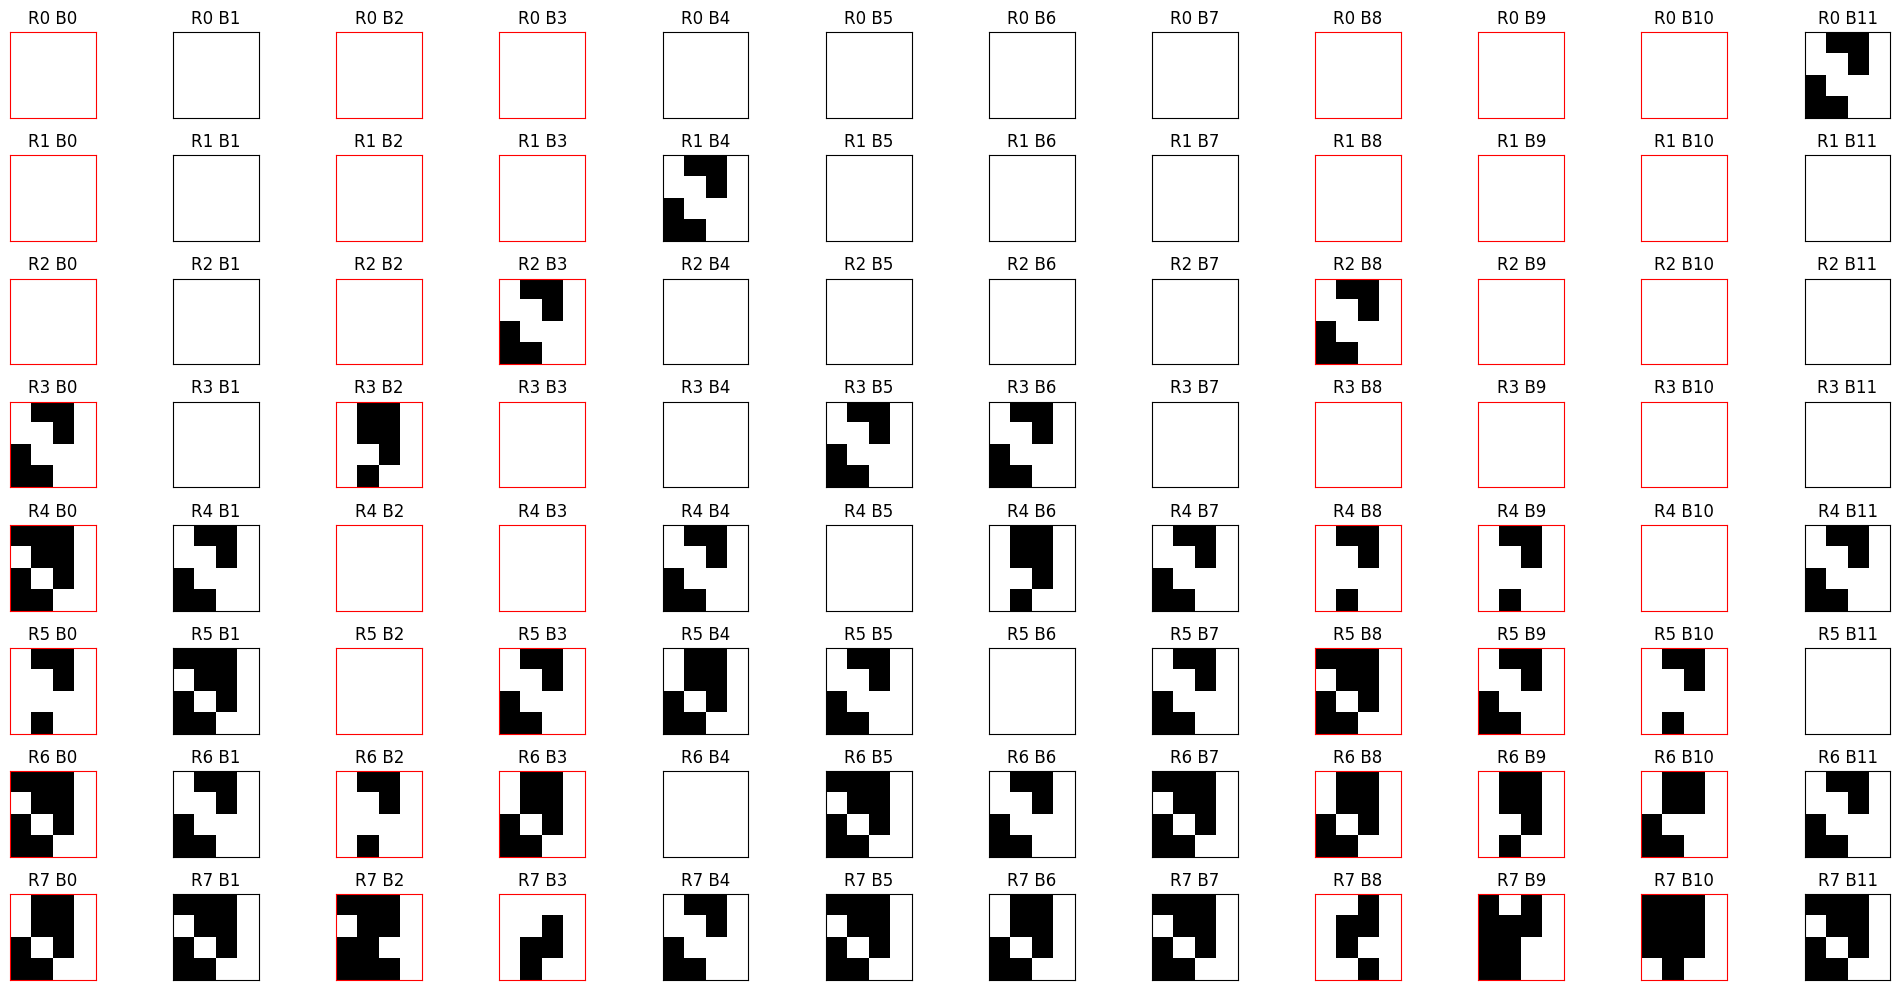

In [2]:
rounds = 8
inbound_begin_round = 2
inbound_end_round = 5
ciphername = "AES_128"
AES_TD = MILPFindReboundPath(ciphername, rounds, inbound_begin_round, inbound_end_round)
# model = MILPFindReboundPath._model
# print("变量数:", model.NumVars)
# print("约束数:", model.NumConstrs)


# #这是用solers的计算
# print("输出一个解:")
# result = AES_TD.solvers()
# if result is not None:
#     solution = result
#     print("截断差分:", solution)
#     # print("经过MDS矩阵活跃列:", mds_solution)
#     inbound_path = solution[inbound_begin_round : inbound_end_round + 1]
# #     inbound_active_mds = mds_solution[inbound_begin_round:inbound_end_round]
#     print("Inbound 阶段路线:", inbound_path)
# #     print("Inbound 阶段活跃列:", inbound_active_mds)
# #     print("\n")
# # else:
# #     print("请选择其他的轮数进行输入")
# print("NumVars =", AES_TD._MILPFindReboundPath__model.NumVars)
# print("NumConstrs =", AES_TD._MILPFindReboundPath__model.NumConstrs)


# 下面是用solver的计算
print("输出一个解:")
result = AES_TD.solver()
if result is not None:
    solution, mds_solution = result[0], result[1]
    print("截断差分:", solution)
    print("经过MDS矩阵活跃列:", mds_solution)
    inbound_path = solution[inbound_begin_round : inbound_end_round + 1]
    inbound_active_mds = mds_solution[inbound_begin_round:inbound_end_round]
    print("Inbound 阶段路线:", inbound_path)
    print("Inbound 阶段活跃列:", inbound_active_mds)
    print("\n")
else:
    print("请选择其他的轮数进行输入")

AES_TD.debug_aes_round_print(r=0, index_in=0, index_out=9)
AES_TD.check_mds_consistency()
AES_TD.debug_print_all_rounds()  # 可选，若解小可以完整打印


import matplotlib.pyplot as plt
import numpy as np

highlight_blocks = [0, 2, 3, 8, 9, 10]

fig, axes = plt.subplots(rounds, 12, figsize=(20, 10))  # 6轮 × 12块
for r in range(rounds):
    for b in range(12):
        block = solution[r][b]
        # print(r, b, block)
        grid = np.array(block).reshape(4, 4).T
        grid = (grid > 0.5).astype(int)
        axes[r, b].imshow(grid, cmap="gray_r", vmin=0, vmax=1)
        axes[r, b].set_title(f"R{r} B{b}")
        axes[r, b].set_xticks([])
        axes[r, b].set_yticks([])

        # 给特定块加红色外框
        if b in highlight_blocks:
            for spine in axes[r, b].spines.values():
                spine.set_edgecolor('red')
                # spine.set_linewidth(2)  # 可调整边框粗细

plt.tight_layout()
plt.show()


######################################rebound friendly自动化搜索的精髓就在于，
#########Inbound中的活跃字节不能太多，否则进入Inbound太容易，两侧收敛不了，Outbound中的
#################非活跃字节不能太多，否则扩散概率太小，Inbound无法产生足够的起始点。另一个重要的约束在于
##############第一层和最后一层的活跃字节也必须尽量少，这样才可能是一个合格的区分器或者碰撞

[[[<gurobi.Var x_0_0_0>, <gurobi.Var x_0_0_1>, <gurobi.Var x_0_0_2>, <gurobi.Var x_0_0_3>, <gurobi.Var x_0_0_4>, <gurobi.Var x_0_0_5>, <gurobi.Var x_0_0_6>, <gurobi.Var x_0_0_7>, <gurobi.Var x_0_0_8>, <gurobi.Var x_0_0_9>, <gurobi.Var x_0_0_10>, <gurobi.Var x_0_0_11>, <gurobi.Var x_0_0_12>, <gurobi.Var x_0_0_13>, <gurobi.Var x_0_0_14>, <gurobi.Var x_0_0_15>], [<gurobi.Var x_0_1_0>, <gurobi.Var x_0_1_1>, <gurobi.Var x_0_1_2>, <gurobi.Var x_0_1_3>, <gurobi.Var x_0_1_4>, <gurobi.Var x_0_1_5>, <gurobi.Var x_0_1_6>, <gurobi.Var x_0_1_7>, <gurobi.Var x_0_1_8>, <gurobi.Var x_0_1_9>, <gurobi.Var x_0_1_10>, <gurobi.Var x_0_1_11>, <gurobi.Var x_0_1_12>, <gurobi.Var x_0_1_13>, <gurobi.Var x_0_1_14>, <gurobi.Var x_0_1_15>], [<gurobi.Var x_0_2_0>, <gurobi.Var x_0_2_1>, <gurobi.Var x_0_2_2>, <gurobi.Var x_0_2_3>, <gurobi.Var x_0_2_4>, <gurobi.Var x_0_2_5>, <gurobi.Var x_0_2_6>, <gurobi.Var x_0_2_7>, <gurobi.Var x_0_2_8>, <gurobi.Var x_0_2_9>, <gurobi.Var x_0_2_10>, <gurobi.Var x_0_2_11>, <gurobi.Var

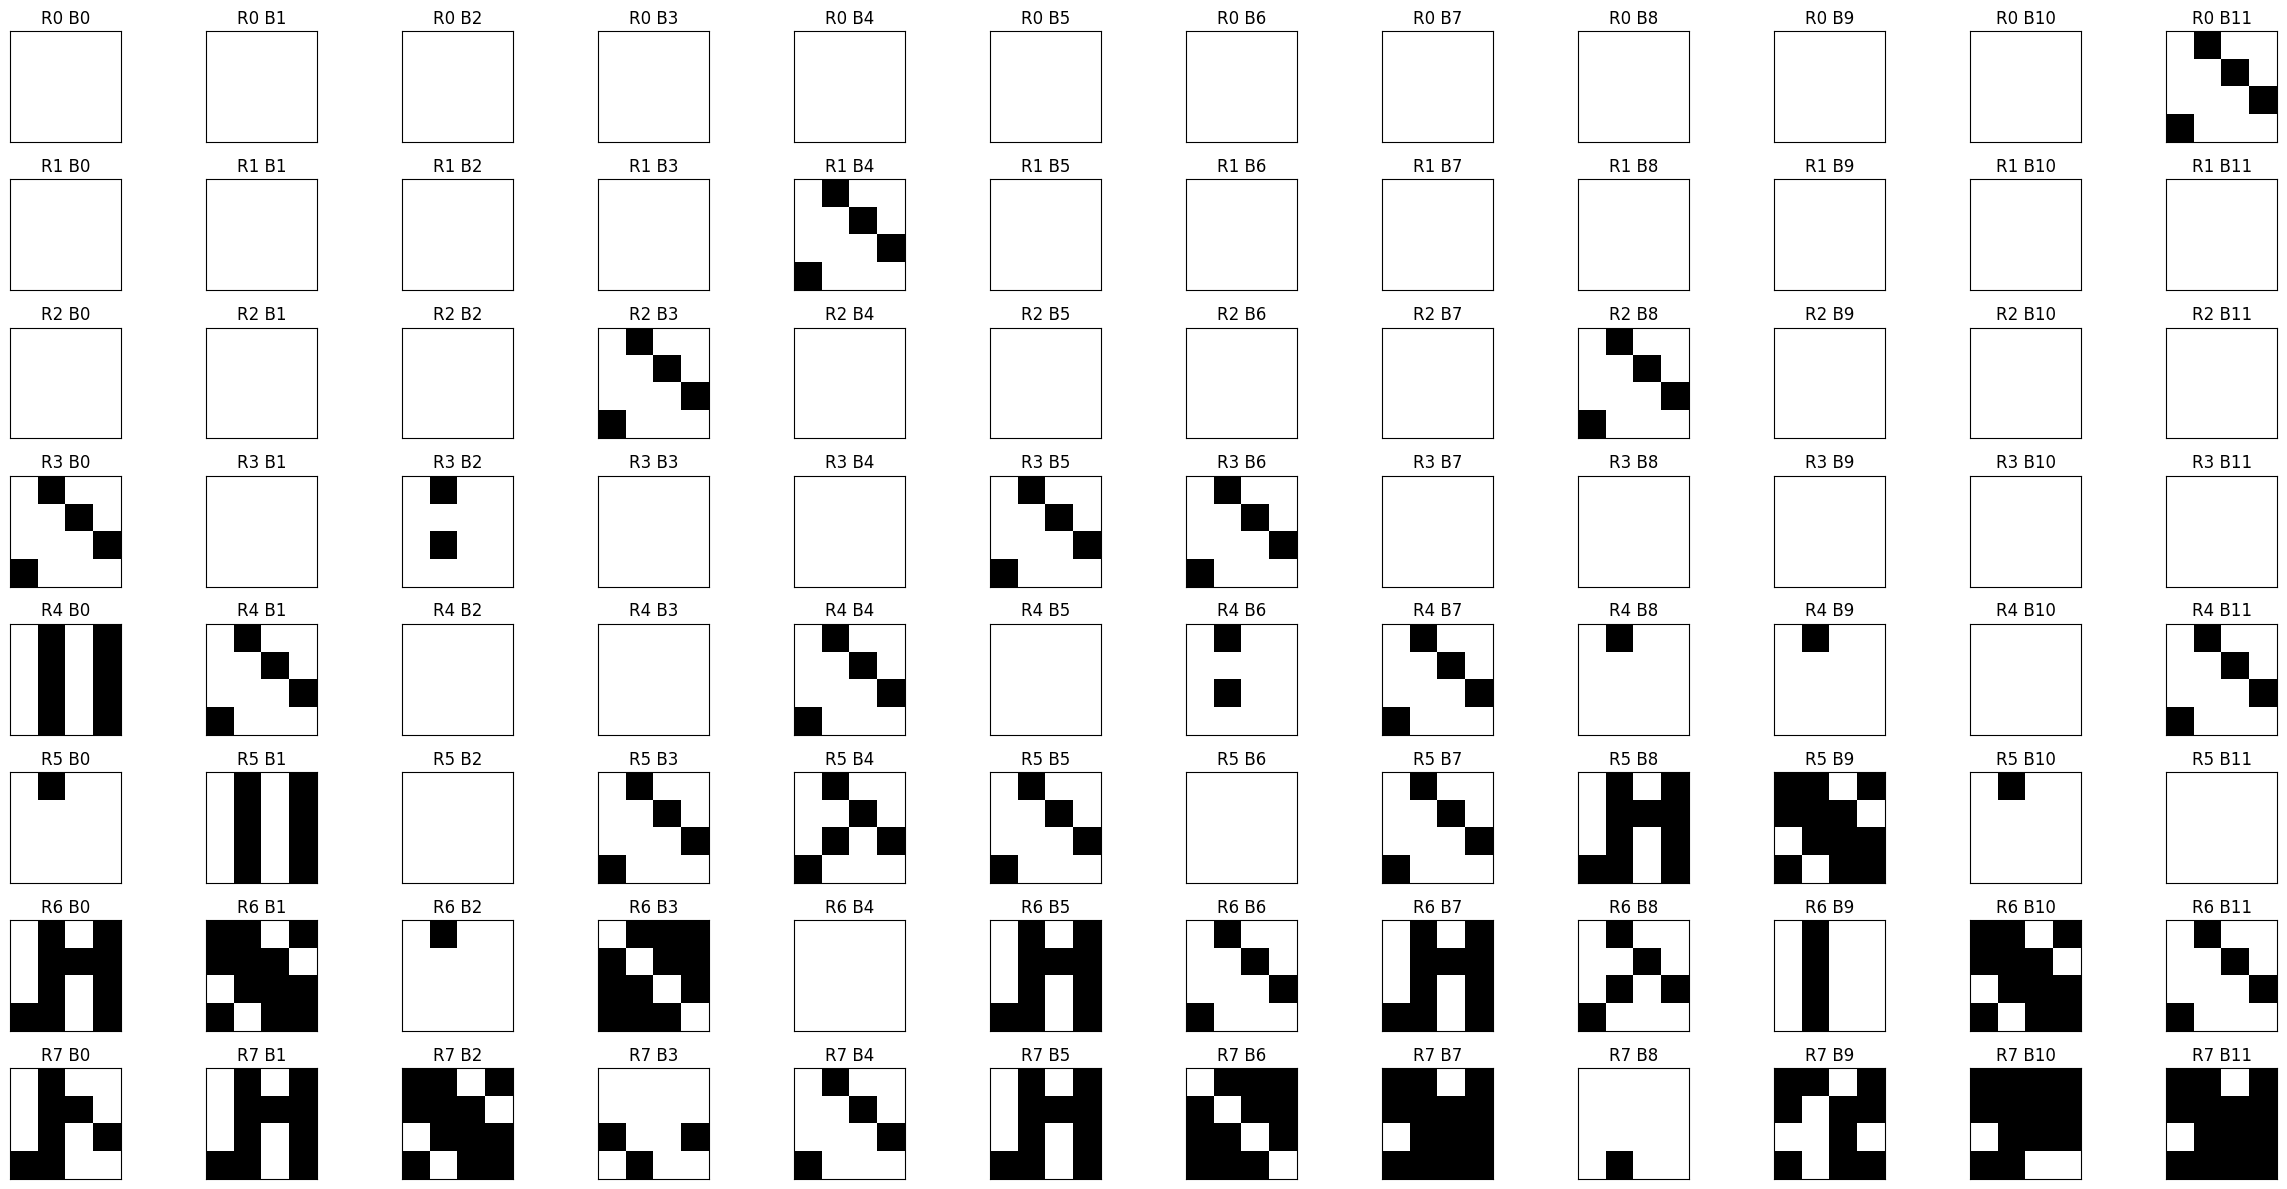

In [32]:
def solve_min_active_sboxes(aes_obj):
    """
    输入：
        aes_obj: MILPFindReboundPath 类的实例
    功能：
        - 构建最小活跃S盒 MILP 模型
        - 求解最优解
        - 返回每轮每块的激活情况 solution 和目标值 obj_value
    """
    import gurobipy as gp
    
    # 1. 清理模型和变量
    aes_obj._MILPFindReboundPath__model = gp.Model()
    aes_obj._MILPFindReboundPath__model.setParam(gp.GRB.Param.OutputFlag, False)
    aes_obj._MILPFindReboundPath__state_vars = []

    # 2. 生成变量
    aes_obj.generate_variables()

    # 3. 构建所有轮的 AES/XOR 置换约束
    aes_obj.Permutation()

    # 4. 设置目标函数：最小化所有比特活跃数量
    aes_obj.set_object_function()

    # 5. 初始化约束：至少一个比特在第0轮被激活
    aes_obj.init_constraints()

    # 6. 求解
    model = aes_obj._MILPFindReboundPath__model
    model.optimize()

    # 7. 解析解
    if model.status == gp.GRB.OPTIMAL:
        rounds = aes_obj._MILPFindReboundPath__rounds
        num_blocks = aes_obj._MILPFindReboundPath__num_blocks
        block_size = aes_obj._MILPFindReboundPath__block_size
        solution = [[[0 for _ in range(block_size)] for _ in range(num_blocks)] for _ in range(rounds)]

        for r in range(rounds):
            for b in range(num_blocks):
                for i in range(block_size):
                    if aes_obj._MILPFindReboundPath__state_vars[r][b][i].xn == 1:
                        solution[r][b][i] = 1

        obj_value = model.getObjective().getValue()
        return solution, obj_value
    else:
        print("未找到最优解")
        return None, None

rounds = 8
aes = MILPFindReboundPath(ciphername="AES_128", rounds=rounds, begin_round=0, end_round=0)
solution, obj = solve_min_active_sboxes(aes)

if solution:
    print("最小活跃S盒数量:", obj)
    # 可视化
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(rounds, aes._MILPFindReboundPath__num_blocks, figsize=(24, 12))
    for r in range(rounds):
        for b in range(aes._MILPFindReboundPath__num_blocks):
            block = solution[r][b]
            grid = np.array(block).reshape(4, 4).T
            axes[r, b].imshow(grid, cmap="gray_r")
            axes[r, b].set_xticks([])
            axes[r, b].set_yticks([])
            axes[r, b].set_title(f"R{r} B{b}")
    plt.tight_layout()
    plt.show()

#######################正确的应该是105个

In [98]:
import tkinter as tk

root = tk.Tk()
root.title("Color Grid")

matrix_size = 4       # 每个小方阵 4x4
layers = 9            # 一共 9 层
cols_per_layer = 12   # 每层 12 个小方阵

# ====== 创建带滚动条的 Canvas 容器 ======
canvas = tk.Canvas(root)
scrollbar_y = tk.Scrollbar(root, orient="vertical", command=canvas.yview)
scrollbar_x = tk.Scrollbar(root, orient="horizontal", command=canvas.xview)

canvas.configure(yscrollcommand=scrollbar_y.set, xscrollcommand=scrollbar_x.set)

scrollbar_y.pack(side="right", fill="y")
scrollbar_x.pack(side="bottom", fill="x")
canvas.pack(side="left", fill="both", expand=True)

# 在 Canvas 里放 Frame
frame = tk.Frame(canvas)
canvas.create_window((0, 0), window=frame, anchor="nw")

# ====== 保存颜色状态（默认白色） ======
grid_colors = [[[[["white"] * matrix_size for _ in range(matrix_size)]
                for _ in range(cols_per_layer)]
               for _ in range(layers)]]

def update_color(row, col, block, layer):
    current_color = grid_colors[0][layer][block][row][col]
    new_color = "gray" if current_color == "white" else "white"  # 白 ↔ 灰 切换
    grid_colors[0][layer][block][row][col] = new_color
    buttons[layer][block][row][col].config(bg=new_color)

buttons = []

for layer in range(layers):
    layer_buttons = []
    for block in range(cols_per_layer):
        # 每个小矩阵外框（红色边界）
        subframe = tk.Frame(frame, highlightbackground="red", highlightthickness=2, padx=1, pady=1)
        subframe.grid(
            row=layer * (matrix_size + 2),   # 层与层之间多留一行
            column=block,
            padx=3, pady=3
        )

        block_buttons = []
        for row in range(matrix_size):
            row_buttons = []
            for col in range(matrix_size):
                button = tk.Button(subframe, width=2, height=1, bg="white",   # 默认白色
                                   command=lambda r=row, c=col, b=block, l=layer: update_color(r, c, b, l))
                button.grid(row=row, column=col, padx=1, pady=1)
                row_buttons.append(button)
            block_buttons.append(row_buttons)
        layer_buttons.append(block_buttons)

        # 在每个小矩阵下面加编号
        label = tk.Label(frame, text=str(block + 1), font=("Arial", 8))
        label.grid(row=layer * (matrix_size + 2) + 1, column=block)

    buttons.append(layer_buttons)

# ====== 自动调整滚动区域 ======
def update_scrollregion(event):
    canvas.configure(scrollregion=canvas.bbox("all"))

frame.bind("<Configure>", update_scrollregion)

root.mainloop()